In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from juno import utils
from pprint import pprint
from juno.juno_custom.elements.Herschel.structures import HerschelSettings, HerschelSimSettings

from LightPipes import *

from juno.juno_custom.tools import sim_tools
import juno.juno_custom.elements.Herschel.utils as h_utils
import matplotlib.pyplot as plt

In [2]:
config = utils.load_yaml_config(config_filename=r'C:\Users\User\Github\juno\juno\juno_custom\configna4881n.yaml')
settings = HerschelSettings.from_dict(config.get('HerschelSettings'))
sim_settings = HerschelSimSettings.from_dict(config.get('HerschelSimSettings'))
wavelength = sim_settings.wavelength
pixel_size= wavelength * 0.5
# media_wavelength = wavelength / 2
# pixel_size = media_wavelength * 0.5

In [3]:
settings.calculate_radii(pixel_size=pixel_size)
raw_profiles = h_utils.create_raw_profiles(settings)
profiles = h_utils.calculate_profiles(settings, raw_profiles, pixel_size)
lenses = h_utils.generate_lenses(settings, profiles)
padded_lenses = h_utils.calculate_padding(profiles=profiles, lenses=lenses, settings=settings, sim_settings=sim_settings, pixel_size=pixel_size)

In [4]:
sim_lens, sim_lens_padding = sim_tools.generate_sim_lens(settings, sim_settings, pixel_size)
sim_lens.profile = sim_lens.profile.max() - sim_lens.profile
sim_wavefront = sim_tools.generate_sim_wavefront(sim_lens=sim_lens, sim_lens_padding=sim_lens_padding, settings=settings, sim_settings=sim_settings)

In [5]:
start = -settings.z_medium_o * 0.95
stop = -settings.z_medium_o * 1.05
start = -settings.z_medium_o * 0
stop = -settings.z_medium_o * 2
start = -settings.z_medium_o * -1#-1.1
stop = -settings.z_medium_o * 0
# start = -settings.z_medium_o * 0#-1.1
# stop = -settings.z_medium_o * 2

step = (stop-start)/(10-1)
distances = np.arange(start, stop, step)
distances = np.append(distances, stop)
output, propagation, output_array = sim_tools.propagate_zero_lens(wavefront=sim_wavefront, 
                                                settings=settings,
                                                sim_settings=sim_settings, 
                                                distances=distances,
                                                pixel_size=pixel_size)

c:\ProgramData\Anaconda3\envs\juno\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


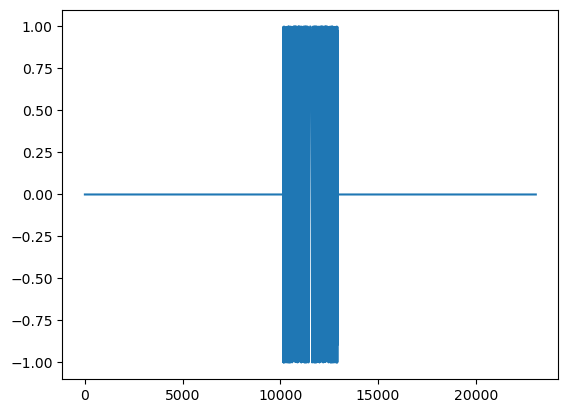

In [6]:
plt.plot(propagation[0])

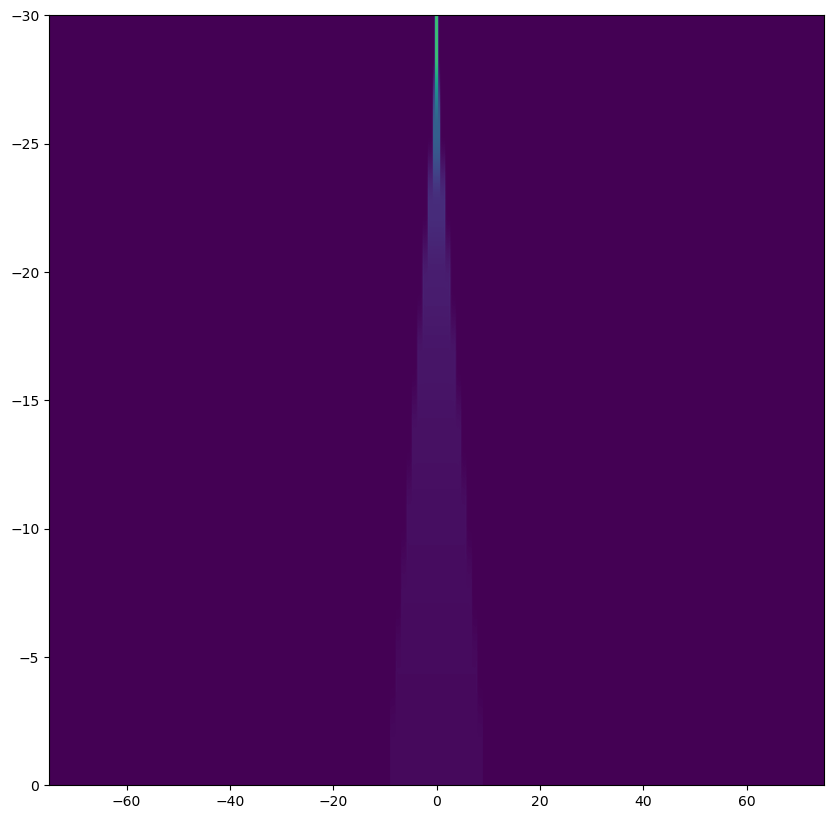

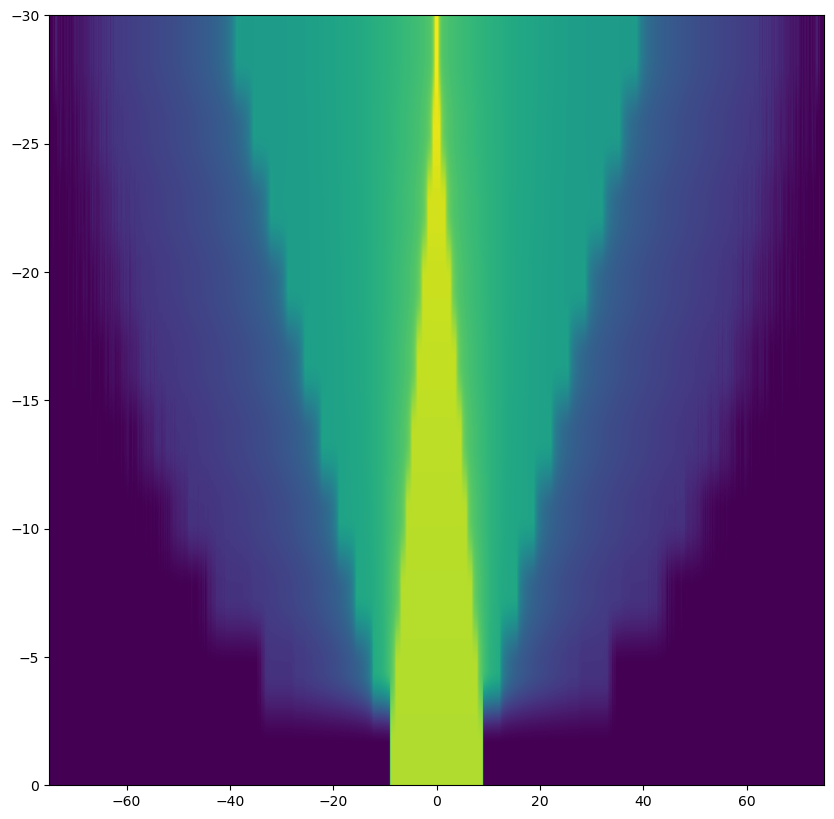

In [7]:
extent = [-output_array.shape[1]*pixel_size/2, output_array.shape[1]*pixel_size/2, distances[-1], distances[0]]

plt.figure(figsize=(10,10))
plt.imshow(output_array, aspect='auto', extent=extent)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(np.log(output_array+1e-12), aspect='auto', extent=extent)
plt.show()

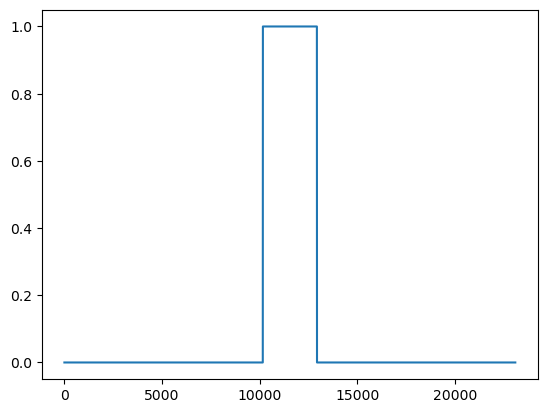

In [8]:
plt.plot(output_array[-1])

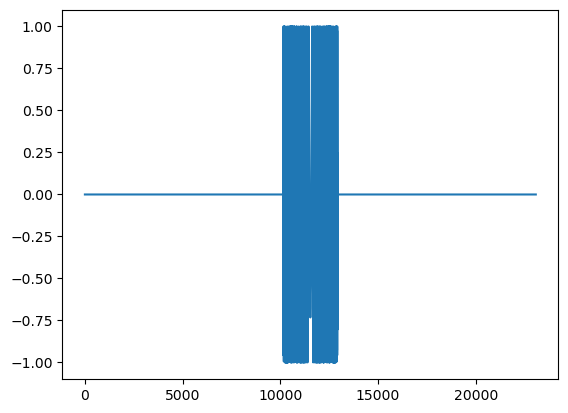

In [9]:
first_wavefront = sim_tools.generate_lens_first_wavefront(lenses=padded_lenses, settings=settings, sim_settings=sim_settings)
plt.plot(first_wavefront[0])

Previous wavefront found


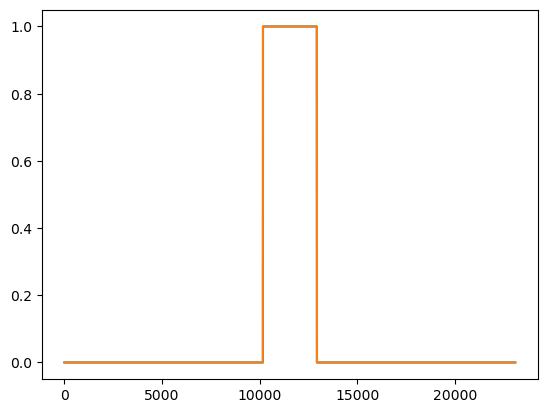

In [10]:
start = 0
stop = settings.thickness
step = (stop-start)/(20-1)
distances = np.arange(start, stop, step)
distances = np.append(distances, stop)

wavefront = np.ones_like(first_wavefront)
wavefront = first_wavefront

plt.plot(np.abs(wavefront[0])**2)
plt.plot(np.abs(propagation[0])**2)

# plt.plot(wavefront[0]*propagation[0])

output2, propagation2, output_array2 = sim_tools.propagate_first_lens(previous_wavefront=propagation, wavefront=wavefront, settings=settings, distances=distances, sim_settings=sim_settings, pixel_size=pixel_size)


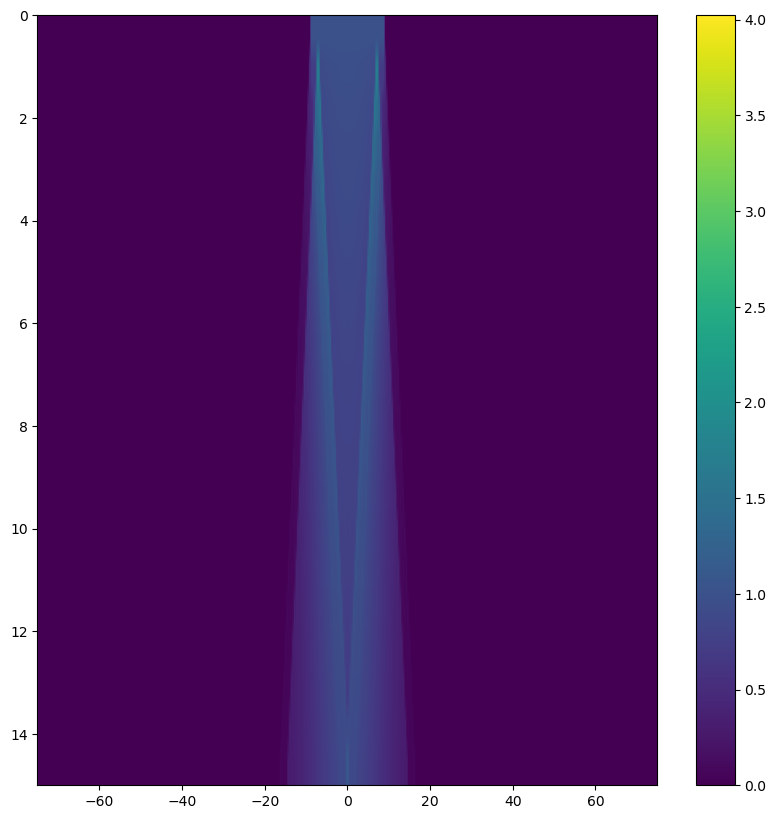

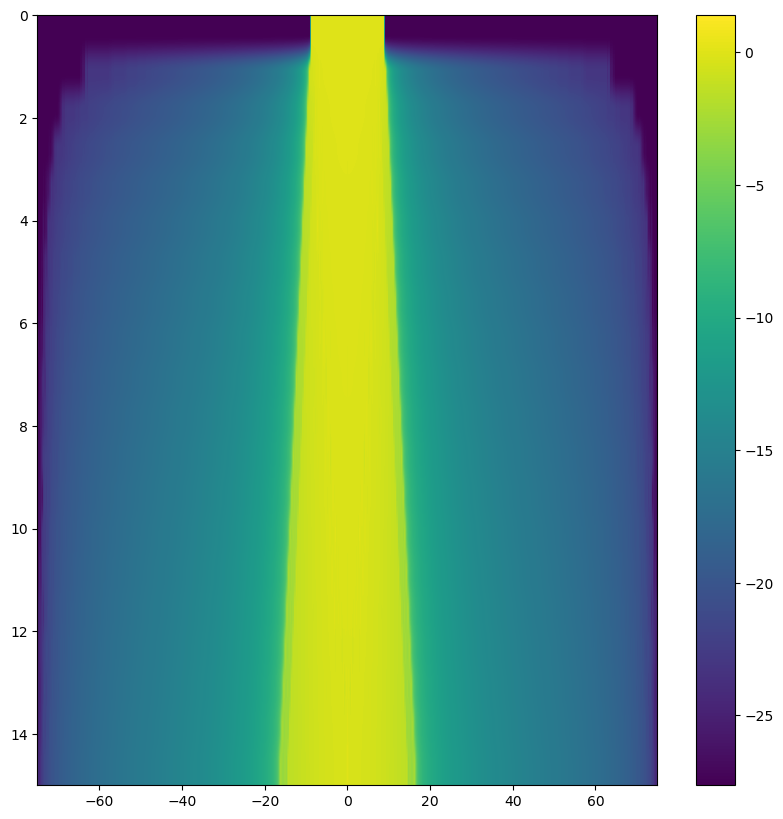

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [11]:
extent = [-output_array2.shape[1]*pixel_size/2, output_array2.shape[1]*pixel_size/2, distances[-1], distances[0]]

plt.figure(figsize=(10,10))
plt.imshow(output_array2, aspect='auto', extent=extent)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(np.log(output_array2+1e-12), aspect='auto', extent=extent)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,10))


In [12]:
wavefront_second = sim_tools.generate_lens_second_wavefront(lenses=padded_lenses, settings=settings, sim_settings=sim_settings)
start = 55
stop = 65
step = (stop-start)/(1000-1)
distances = np.arange(start, stop, step)
distances = np.append(distances, stop)
print(f"Step: {step}")
output3, propagation3, output_array3 = sim_tools.propagate_second_lens(previous_wavefront=propagation2, wavefront=wavefront_second, settings=settings, distances=distances, sim_settings=sim_settings, pixel_size=pixel_size)


Step: 0.01001001001001001


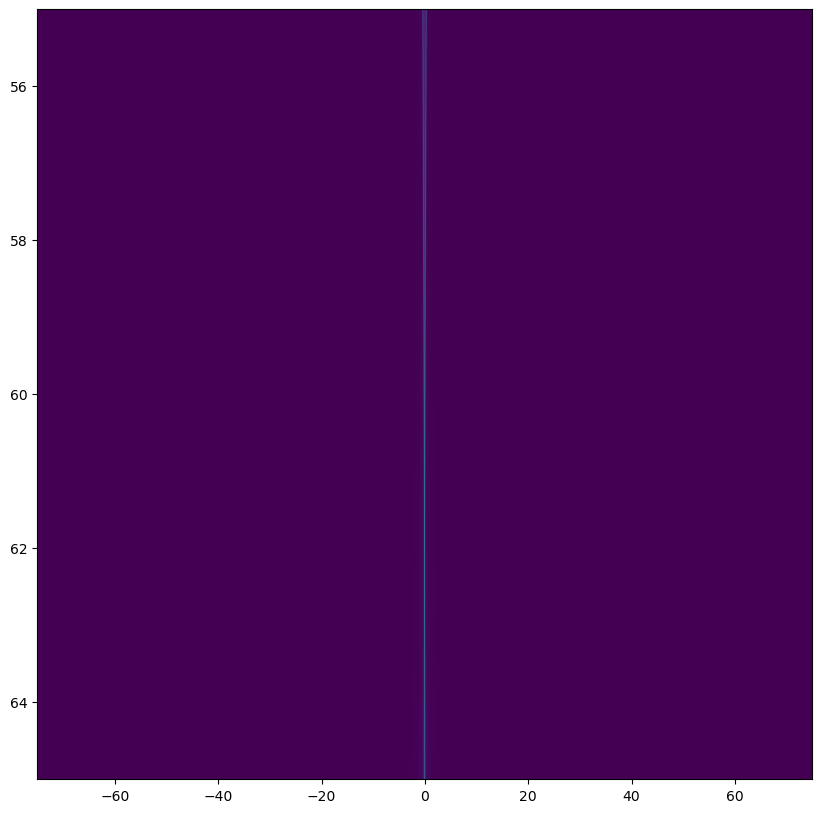

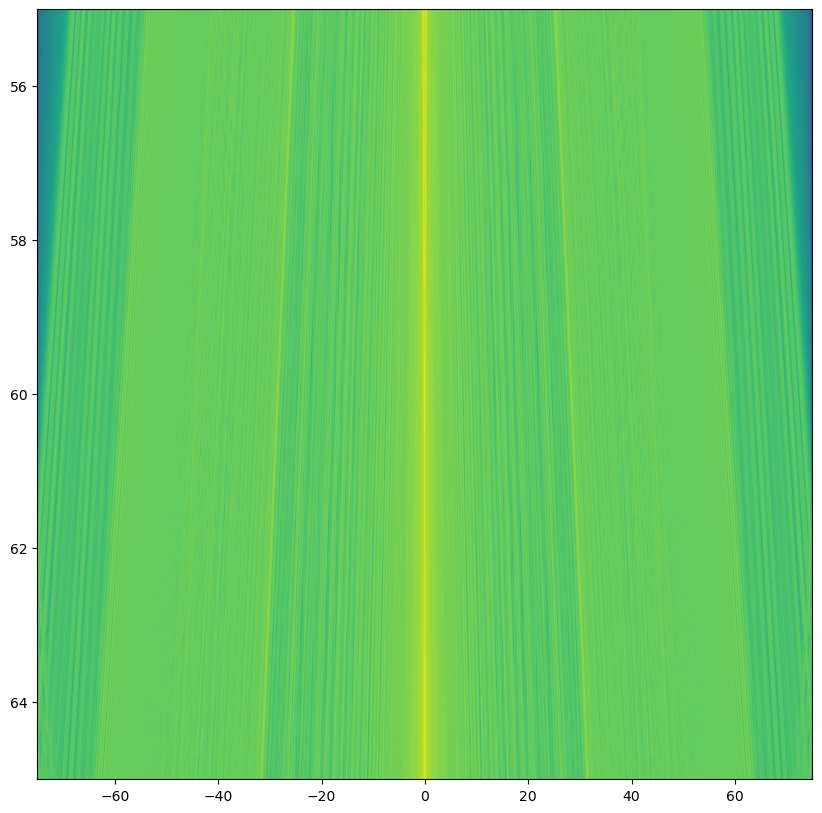

In [13]:
extent = [-output_array3.shape[1]*pixel_size/2, output_array3.shape[1]*pixel_size/2, distances[-1], distances[0]]

plt.figure(figsize=(10,10))
plt.imshow(output_array3, aspect='auto', extent=extent)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(np.log(output_array3+1e-12), aspect='auto', extent=extent)
plt.show()

In [14]:
print(step)
print(50/step)

0.01001001001001001
4995.0


In [15]:
cy = output_array3.shape[0]//2
cx = output_array3.shape[1]//2

width = 200

zoomed_array = output_array3[:, cx-width//2:cx+width//2]
# zoomed_array = output_array3[100:140, cx-width//2:cx+width//2]

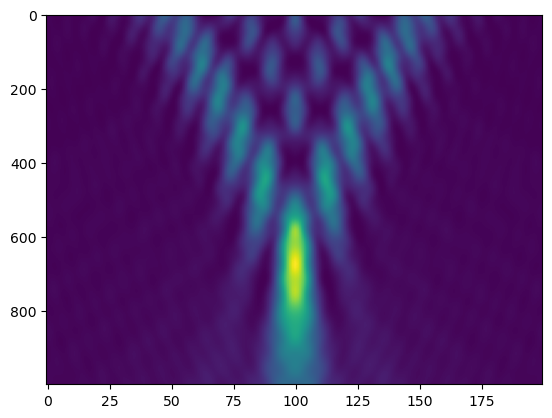

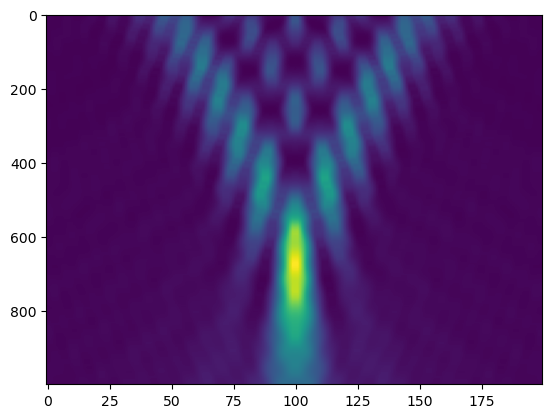

In [16]:
plt.imshow(zoomed_array, aspect='auto')

plt.show()

#  median filter
from scipy.ndimage import median_filter
plt.imshow(median_filter(zoomed_array, size=5), aspect='auto')

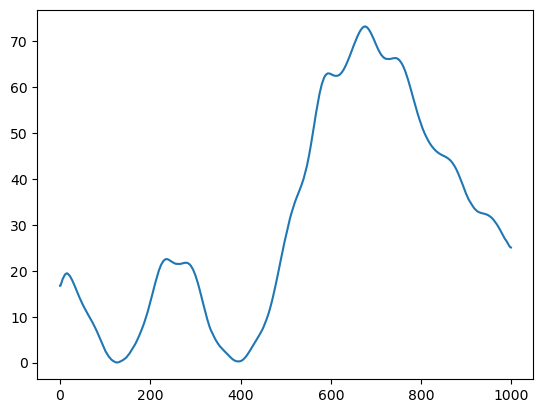

In [17]:
central_line = median_filter(zoomed_array, size=5)[:, width//2]
plt.plot(central_line)
halfmax = np.max(central_line)/2

In [18]:
argmax = np.argmax(central_line)
print(argmax*step)
print(start + argmax*step)

6.766766766766767
61.766766766766764


In [19]:
# halfmax = np.max(zoomed_array)/2
zoomed_binary = zoomed_array > halfmax
zoomed_halfmax = zoomed_array*zoomed_binary

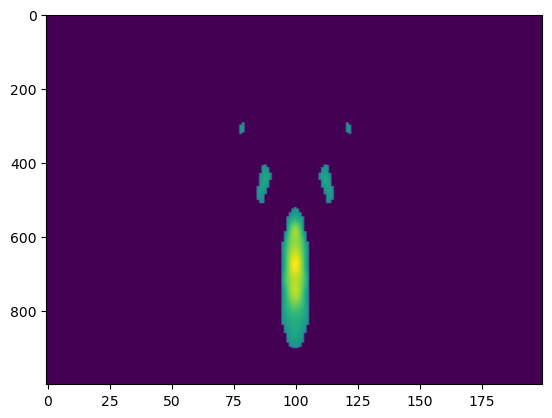

In [20]:
plt.imshow(zoomed_halfmax, aspect='auto')

In [21]:
from juno.lightsheet import light_sheet

3.823823823823824
0.078


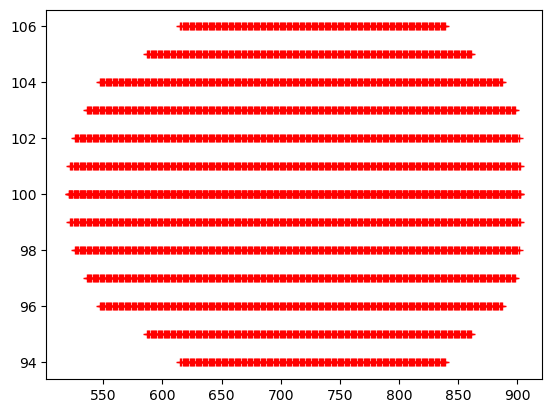

In [22]:
len_px, wid_px, (x, y) = light_sheet.calculate_sheet_size_pixels(zoomed_halfmax, 0.5)
print(len_px * step)
print(wid_px * pixel_size)
plt.plot(x, y, 'r+')

In [23]:
print(start + x[0]*step)
print(start + x[-1]*step)
print(start + (x[-1]+x[0])/2*step)

60.21521521521522
64.02902902902903
62.12212212212212


In [24]:
print(y[0]*pixel_size)
print(y[-1]*pixel_size)

0.65
0.6435


In [25]:
62.12212 - 60.25525525525526

1.8668647447447455